Successfully loaded file: /Users/danabalbuena/Downloads/WNBA Stats.csv
Found 31 unique players in the top 10 across all 5 categories.
Generated 'elbow_plot.png' (for k selection).

Cluster Summary (Mean Stats and Examples):
|   Cluster |   REB |   AST |   STL |   BLK |   PTS | Example_Players                       |
|----------:|------:|------:|------:|------:|------:|:--------------------------------------|
|         0 | 102.1 | 119.8 |  37.7 |   9   | 377.9 | ['Alana Beard', 'Allisha Gray']       |
|         1 | 271.1 |  67.4 |  35.9 |  36.6 | 531.1 | ['Breanna Stewart', 'Candace Parker'] |
|         2 | 188.3 |  40.3 |  20.7 |  37.8 | 297.8 | ['Brittney Griner', 'Diana Taurasi']  |
Generated 'cluster_means.png' (for cluster characteristic figure).


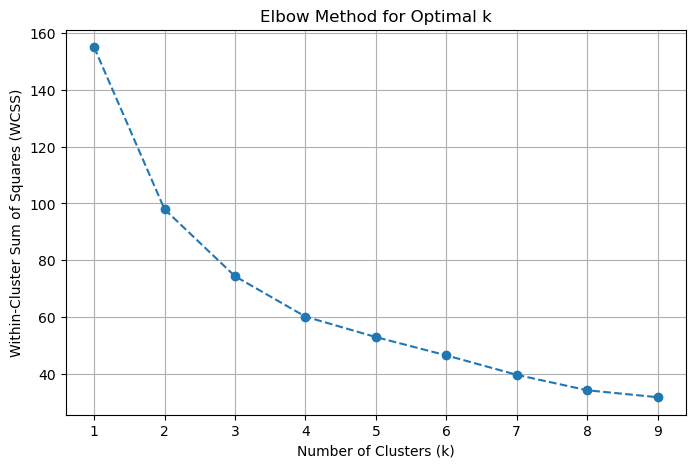

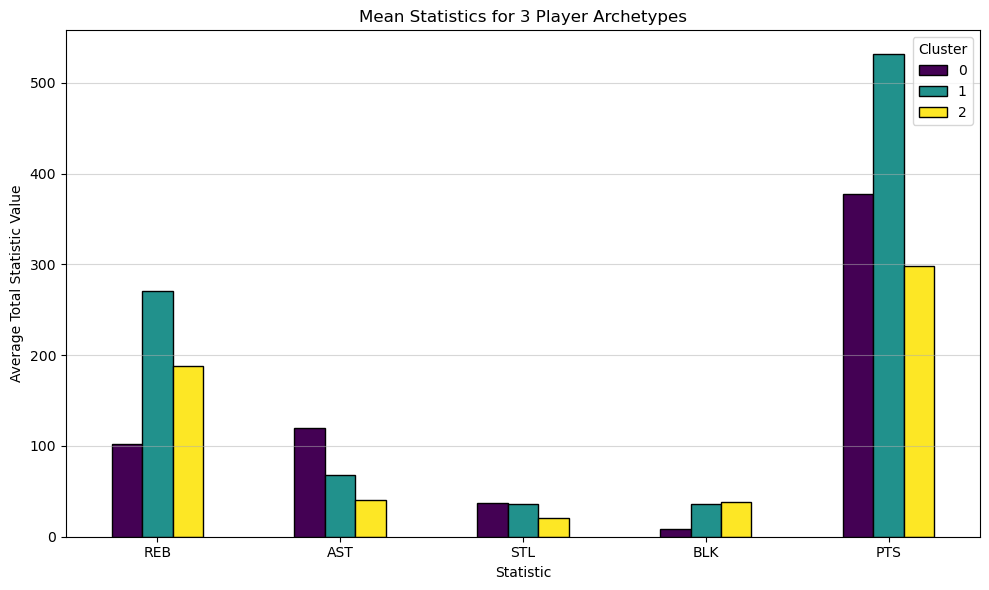

In [12]:
import pandas as pd
from io import StringIO
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

def perform_wnba_clustering(file_content):
    """
    Performs K-Means clustering on the top WNBA players based on key stats.

    Args:
        file_content (str): The content of the WNBA Stats CSV file.
    """
    # 1. Load the data
    try:
        df = pd.read_csv("/Users/danabalbuena/Downloads/WNBA Stats.csv")
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    # --- Data Subsetting (Top Performers) ---
    stats_cols = ['REB', 'AST', 'STL', 'BLK', 'PTS']
    top_players_set = set()

    # Get the top 10 players for each of the 5 stats and collect their names
    for col in stats_cols:
        # Use nlargest to get the top 10 players by each stat
        top_10 = df.nlargest(10, col)['Name'].tolist()
        top_players_set.update(top_10)

    # Filter the DataFrame to include only the top performers
    top_performers_df = df[df['Name'].isin(top_players_set)].copy()
    top_performers_df.reset_index(drop=True, inplace=True)

    print(f"Found {len(top_performers_df)} unique players in the top 10 across all 5 categories.")

    # Select features for clustering
    X = top_performers_df[stats_cols]

    # --- 2. Feature Scaling ---
    # Standardize the data so each feature contributes equally to the distance calculation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # --- 3. Elbow Method for K selection ---
    wcss = [] # Within-Cluster Sum of Squares
    max_k = 10
    for i in range(1, max_k):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)

    # Plot the Elbow Method results (for the Medium Post justification)
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_k), wcss, marker='o', linestyle='--')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    plt.grid(True)
    plt.xticks(range(1, max_k))
    plt.savefig('elbow_plot.png')
    print("Generated 'elbow_plot.png' (for k selection).")

    # --- 4. K-Means Clustering with selected k=3 ---
    k_optimal = 3
    kmeans = KMeans(n_clusters=k_optimal, init='k-means++', random_state=42, n_init=10)
    top_performers_df['Cluster'] = kmeans.fit_predict(X_scaled)

    # --- 5. Characterize and Summarize Clusters ---
    
    cluster_summary = top_performers_df.groupby('Cluster')[stats_cols].mean().reset_index()
    
    # Get player examples for the post
    examples = top_performers_df.groupby('Cluster')['Name'].apply(lambda x: x.iloc[:2].tolist()).reset_index()
    examples.columns = ['Cluster', 'Example_Players']
    
    # Merge summary and examples
    cluster_summary = cluster_summary.merge(examples, on='Cluster')

    # Round the mean values for clean presentation
    for col in stats_cols:
        cluster_summary[col] = cluster_summary[col].round(1)

    print("\nCluster Summary (Mean Stats and Examples):")
    print(cluster_summary.to_markdown(index=False))

    # --- 6. Generate Cluster Means Plot for Visualization ---
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
    cluster_centers_df = pd.DataFrame(cluster_centers, columns=stats_cols)
    cluster_centers_df.index.name = 'Cluster'

    # Plot the cluster means for visualization (Cluster Archetype Figure)
    cluster_centers_df.T.plot(kind='bar', figsize=(10, 6), rot=0, 
                             cmap='viridis', edgecolor='black')
    plt.title(f'Mean Statistics for {k_optimal} Player Archetypes')
    plt.ylabel('Average Total Statistic Value')
    plt.xlabel('Statistic')
    plt.legend(title='Cluster', loc='upper right')
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.savefig('cluster_means.png')
    print("Generated 'cluster_means.png' (for cluster characteristic figure).")

if __name__ == "__main__":
    csv_file_name = "/Users/danabalbuena/Downloads/WNBA Stats.csv"
    
    try:
        # This opens the file and reads all its content into a string
        with open(csv_file_name, 'r', encoding='utf-8') as f:
            csv_content = f.read()
        
        print(f"Successfully loaded file: {csv_file_name}")
        
        perform_wnba_clustering(csv_content)
        
    except FileNotFoundError:
        print(f"ERROR: The file '{csv_file_name}' was not found.")
        print("Please make sure 'WNBA Stats.csv' is in the same folder as this script.")
    except Exception as e:
        print(f"An unexpected error occurred during execution: {e}")